# tf.nn.softmax(0 でマルチクラス分類を解く

<code>
    tf.nn.softmax(
        logits [,
        axis= -1,
        name = None
    ])
</code>

<pre>
    logits: sotmax関数を適用する Tensor オブジェクト
    axis: softmax の次元を指定する。デフォルトは最後の次元を表す -1。
    name: 操作名
</pre>

In [1]:
# 4-02-2 訓練データと検証データの用意
# p.174

import numpy as np

np.random.seed(123)

input_dim = 2
n = 500

x1 = np.random.randn(n, input_dim) + np.array([0, 6])   # [0,6] の周りに500個の点
x2 = np.random.randn(n, input_dim) + np.array([4, 3])   # [4,3] の周りに500個の点
x3 = np.random.randn(n, input_dim) + np.array([8, 0])   # [8,0] の周りに500個の点

t1 = np.array([[1, 0, 0] for i in range(n)])  # one hot vector
t2 = np.array([[0, 1, 0] for i in range(n)])  # one hot vector
t3 = np.array([[0, 0, 1] for i in range(n)])  # one hot vector

x = np.concatenate((x1, x2, x3), axis=0)   # 縦方向に連結
t = np.concatenate((t1, t2, t3), axis=0)

x = x.astype('float32')
t = t.astype('float32')

In [2]:
from sklearn.model_selection import train_test_split

x_train, x_validation, t_train, t_validation = train_test_split(x, t, test_size=0.2)

print(x_train.shape)
print(t_train.shape)
print(x_validation.shape)
print(t_validation.shape)

(1200, 2)
(1200, 3)
(300, 2)
(300, 3)


In [3]:
tidx_c0 = [i for i in range(len(x_train)) if t_train[i,0] == 1]
tidx_c1 = [i for i in range(len(x_train)) if t_train[i,1] == 1]
tidx_c2 = [i for i in range(len(x_train)) if t_train[i,2] == 1]
print(len(tidx_c0))
print(len(tidx_c1))
print(len(tidx_c2))

395
399
406


In [4]:
vidx_c0 = [i for i in range(len(x_validation)) if t_validation[i,0] == 1]
vidx_c1 = [i for i in range(len(x_validation)) if t_validation[i,1] == 1]
vidx_c2 = [i for i in range(len(x_validation)) if t_validation[i,2] == 1]
print(len(vidx_c0))
print(len(vidx_c1))
print(len(vidx_c2))

105
101
94


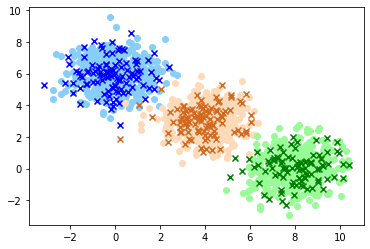

In [5]:
# 4-02-3 改 訓練データと検証データを表示する
# p.175

%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(6,4))

# training data
ax.scatter(x_train[tidx_c0,0], x_train[tidx_c0,1],c='lightskyblue')
ax.scatter(x_train[tidx_c1,0], x_train[tidx_c1,1],c='peachpuff')
ax.scatter(x_train[tidx_c2,0], x_train[tidx_c2,1],c='palegreen')

# validation data
ax.scatter(x_validation[vidx_c0,0], x_validation[vidx_c0,1],c='blue', marker='x')
ax.scatter(x_validation[vidx_c1,0], x_validation[vidx_c1,1],c='chocolate', marker='x')
ax.scatter(x_validation[vidx_c2,0], x_validation[vidx_c2,1],c='green', marker='x')

plt.show()

In [6]:
# 4-02-4 Model のサブクラスの定義
# p.177
import tensorflow as tf

class MLP(tf.keras.Model):
    
    def __init__(self, hidden_dim, output_dim):
        super().__init__()
        self.l1 = tf.keras.layers.Dense(hidden_dim, activation='sigmoid')
        self.l2 = tf.keras.layers.Dense(output_dim, activation='sigmoid')
        
    def call(self, x):
        h = self.l1(x)
        y = self.l2(h)
        return y

In [7]:
# 4-02-5 クロスエントロピー誤差関数
# p.179

cce = tf.keras.losses.CategoricalCrossentropy()

def loss(t, y):
    return cce(t, y)

In [8]:
# 04-02-6 バックプロパゲーションを実行する関数の定義
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)

train_loss = tf.keras.metrics.Mean()
train_acc = tf.keras.metrics.CategoricalAccuracy()

@tf.function
def train_step(x, t):
    with tf.GradientTape() as tape:
        outputs = model(x)
        tmp_loss = loss(t, outputs)
    grads = tape.gradient(tmp_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    train_loss(tmp_loss) # 損失をMeanオブジェクトに記録する
    train_acc(t, outputs) # 精度をCategoricalAccuracyオブジェクトに記録する
    
    return tmp_loss

In [9]:
# 4-02-7 学習を行う
# p.184

from sklearn.utils import shuffle

epochs = 500
batch_size = 32
steps = x_train.shape[0] // batch_size

model = MLP(2, 3)

for epoch in range(epochs):
    x_, t_ = shuffle(x_train, t_train, random_state=1)
    
    for step in range(steps):
        #start = steps * step  # bug?
        start = batch_size * step  # bug fix by nitta 2021/02/26
        end = start + batch_size
        tmp_loss = train_step(x_[start:end], t_[start:end])
        
    if (epoch + 1) % 20 == 0:
        print(f'epoch: {epoch+1} train_loss: {train_loss.result(): .4f}  train_acc: {train_acc.result():.4f}')

epoch: 20 train_loss:  0.6961  train_acc: 0.5916
epoch: 40 train_loss:  0.6025  train_acc: 0.6340
epoch: 60 train_loss:  0.5614  train_acc: 0.6641
epoch: 80 train_loss:  0.4581  train_acc: 0.7428
epoch: 100 train_loss:  0.3814  train_acc: 0.7904
epoch: 120 train_loss:  0.3276  train_acc: 0.8226
epoch: 140 train_loss:  0.2878  train_acc: 0.8458
epoch: 160 train_loss:  0.2572  train_acc: 0.8637
epoch: 180 train_loss:  0.2328  train_acc: 0.8777
epoch: 200 train_loss:  0.2129  train_acc: 0.8890
epoch: 220 train_loss:  0.1963  train_acc: 0.8983
epoch: 240 train_loss:  0.1824  train_acc: 0.9061
epoch: 260 train_loss:  0.1704  train_acc: 0.9128
epoch: 280 train_loss:  0.1600  train_acc: 0.9185
epoch: 300 train_loss:  0.1510  train_acc: 0.9236
epoch: 320 train_loss:  0.1430  train_acc: 0.9281
epoch: 340 train_loss:  0.1359  train_acc: 0.9320
epoch: 360 train_loss:  0.1295  train_acc: 0.9355
epoch: 380 train_loss:  0.1238  train_acc: 0.9386
epoch: 400 train_loss:  0.1186  train_acc: 0.9415
epoc

In [10]:
# 4-02-8 検証データでもモデルを評価する
# p.186

val_preds = model(x_validation)
categor_acc = tf.keras.metrics.CategoricalAccuracy()
categor_acc.update_state(t_validation, val_preds)
validation_acc = categor_acc.result().numpy()
validation_loss = loss(t_validation, val_preds)

print(f'validation_loss: {validation_loss:.4f} validation_acc: {validation_acc:.4f}')

validation_loss: 0.0252 validation_acc: 0.9900


## Keras (tensorflow.keras) によるプログラミング

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers

model2 = Sequential()
model2.add(Dense(2, activation='sigmoid'))
model2.add(Dense(3, activation='sigmoid'))

optimizer2 = optimizers.SGD(learning_rate=0.1)
model2.compile(optimizer=optimizer2,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
history = model2.fit(
    x,
    t,
    epochs=500,
    batch_size=32,
    verbose=1,
    validation_split=0.2
)

Epoch 1/500
38/38 [==============================] - 1s 7ms/step - loss: 0.9539 - accuracy: 0.4950 - val_loss: 1.3789 - val_accuracy: 0.0000e+00
Epoch 2/500
38/38 [==============================] - 0s 3ms/step - loss: 0.7127 - accuracy: 0.8150 - val_loss: 1.3797 - val_accuracy: 0.0000e+00
Epoch 3/500
38/38 [==============================] - 0s 3ms/step - loss: 0.5667 - accuracy: 0.8250 - val_loss: 1.2221 - val_accuracy: 0.0000e+00
Epoch 4/500
38/38 [==============================] - 0s 3ms/step - loss: 0.4728 - accuracy: 0.8250 - val_loss: 1.0641 - val_accuracy: 0.0000e+00
Epoch 5/500
38/38 [==============================] - 0s 3ms/step - loss: 0.4029 - accuracy: 0.8342 - val_loss: 0.8933 - val_accuracy: 0.4433
Epoch 6/500
38/38 [==============================] - 0s 3ms/step - loss: 0.3488 - accuracy: 0.9367 - val_loss: 0.7870 - val_accuracy: 0.8100
Epoch 7/500
38/38 [==============================] - 0s 3ms/step - loss: 0.3061 - accuracy: 0.9750 - val_loss: 0.6960 - val_accuracy: 0.90

## [自習] Keras の Functional API で記述する。

training 用データとvalidation 用データを指定する場合は以下のように書けばよい。
4.1章ではこのようなコードを書いた。

<code>
history3 = model3.fit(
    x_train,
    t_train,
    epochs=500,
    batch_size=32,
    verbose=1,
    validation_data=(x_validation, t_validation)
)
</code>

下の例では、Model.fit()の際にデータ全体を与えて、検証の割合を数字で与えている。

In [13]:
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers

input = tf.keras.Input(shape=(2), dtype='float32')
H = Dense(2, activation='sigmoid')(input)
H = Dense(3, activation='sigmoid')(H)

model3 = tf.keras.Model(inputs=input, outputs=H)

optimizer3 = optimizers.SGD(learning_rate = 0.1)
model3.compile(optimizer = optimizer3,
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])

In [14]:
history3 = model3.fit(
    x,
    t,
    epochs=500,
    batch_size=32,
    verbose=1,
    validation_split=0.2
)

Epoch 1/500
38/38 [==============================] - 1s 6ms/step - loss: 0.7899 - accuracy: 0.7142 - val_loss: 1.3161 - val_accuracy: 0.0000e+00
Epoch 2/500
38/38 [==============================] - 0s 4ms/step - loss: 0.6061 - accuracy: 0.8242 - val_loss: 1.2215 - val_accuracy: 0.0000e+00
Epoch 3/500
38/38 [==============================] - 0s 4ms/step - loss: 0.5049 - accuracy: 0.8250 - val_loss: 1.1173 - val_accuracy: 0.0000e+00
Epoch 4/500
38/38 [==============================] - 0s 3ms/step - loss: 0.4296 - accuracy: 0.8258 - val_loss: 0.9910 - val_accuracy: 0.0000e+00
Epoch 5/500
38/38 [==============================] - 0s 4ms/step - loss: 0.3710 - accuracy: 0.8800 - val_loss: 0.8382 - val_accuracy: 0.7900
Epoch 6/500
38/38 [==============================] - 0s 3ms/step - loss: 0.3253 - accuracy: 0.9717 - val_loss: 0.7588 - val_accuracy: 0.8800
Epoch 7/500
38/38 [==============================] - 0s 3ms/step - loss: 0.2881 - accuracy: 0.9800 - val_loss: 0.6760 - val_accuracy: 0.90

In [15]:
n_grid = 100
px = np.linspace(-4, 11, n_grid)
py = np.linspace(-4, 11, n_grid)
xv, yv = np.meshgrid(px, py)
xv = xv.flatten()
yv = yv.flatten()
z_grid = np.array(list(zip(xv, yv)))

predicts = model3.predict(z_grid)
print(len(predicts))

classes = np.argmax(predicts, axis=1) # one-hot vector --> class id
    
idx0 = [i for i in range(len(z_grid)) if classes[i] == 0]
idx1 = [i for i in range(len(z_grid)) if classes[i] == 1]
idx2 = [i for i in range(len(z_grid)) if classes[i] == 2]

print(len(idx0))
print(len(idx1))
print(len(idx2))

10000
3346
4301
2353


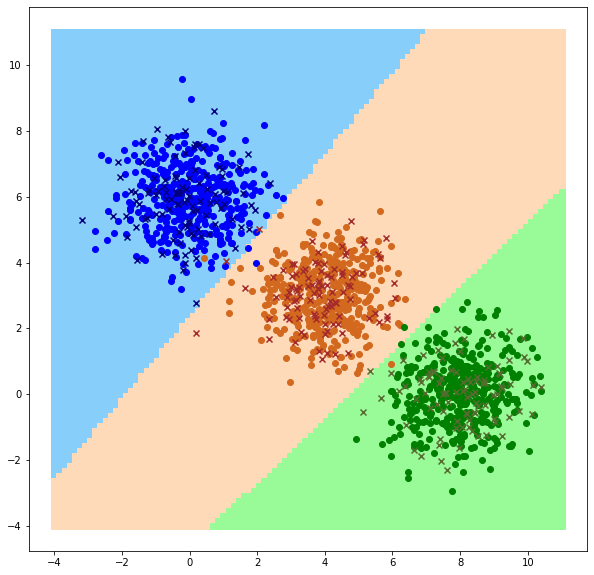

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10,10))

# background
ax.scatter(z_grid[idx0,0], z_grid[idx0,1], marker='s', color='lightskyblue')
ax.scatter(z_grid[idx1,0], z_grid[idx1,1], marker='s', color='peachpuff')
ax.scatter(z_grid[idx2,0], z_grid[idx2,1], marker='s', color='palegreen')

# training data
ax.scatter(x_train[tidx_c0,0], x_train[tidx_c0,1],c='blue')
ax.scatter(x_train[tidx_c1,0], x_train[tidx_c1,1],c='chocolate')
ax.scatter(x_train[tidx_c2,0], x_train[tidx_c2,1],c='green')

# validation data
ax.scatter(x_validation[vidx_c0,0], x_validation[vidx_c0,1],c='navy', marker='x')
ax.scatter(x_validation[vidx_c1,0], x_validation[vidx_c1,1],c='brown', marker='x')
ax.scatter(x_validation[vidx_c2,0], x_validation[vidx_c2,1],c='darkolivegreen', marker='x')

plt.show()
